In [34]:
import numpy as np
import sympy as sp
import pickle

from scipy.integrate import trapz,cumulative_trapezoid,quad

import os, time

from qutip import *
import matplotlib.pyplot as plt
from sympy.physics.quantum import TensorProduct as ts
from sympy.physics.quantum.dagger import Dagger
from sympy.physics.matrices import msigma

from sympy import lambdify

In [10]:
# ------------------  HCD-------------------------
def HCD(TT):
    sI,sx,sy,sz = sp.eye(2),msigma(1),msigma(2),msigma(3)
    
    t = sp.symbols(r't', real=True, positive=True)
    f = sp.Function('f')(t)
    g = sp.Function('g')(t)

    f, g = t/TT, t/TT

    sHi = (ts(sx,sx,sI)+ts(sy,sy,sI))
    sHm = (ts(sI,sx,sx)+ts(sI,sy,sy))
    sHf = (ts(sz,sI,sz) + ts(sI,sz,sz))

    sHad = (1-f)*sHi + f*(1-f)*sHm + g*sHf
    
    m = sHad.eigenvects(chop=True)
    
    e = [m[i//2][0] for i in range(len(m)*2)]
    ev_ = [[tup[2][0], tup[2][1]] for tup in m]
    ev = [val for sublist in ev_ for val in sublist]
    evN = [vec/sp.sqrt((Dagger(vec)*vec)[0]) for vec in ev] 

    sHcd = sum([1j*sp.diff(vec,t)*Dagger(vec) for vec in evN],sp.zeros(8,8))
    
    return sHcd
# -------------------------------------------------------------------------
def HAD(TT):
    sI,sx,sy,sz = sp.eye(2),msigma(1),msigma(2),msigma(3)
    
    t = sp.symbols(r't', real=True, positive=True)
    f = sp.Function('f')(t)
    g = sp.Function('g')(t)

    f, g = t/TT, t/TT

    sHi = (ts(sx,sx,sI)+ts(sy,sy,sI))
    sHm = (ts(sI,sx,sx)+ts(sI,sy,sy))
    sHf = (ts(sz,sI,sz) + ts(sI,sz,sz))

    sHad = (1-f)*sHi + f*(1-f)*sHm + g*sHf

    return sHad
# -------------------------------------------------------------------------
def save_Had(TT):
    t = sp.symbols(r't', real=True, positive=True)
    H = HAD(TT)
    nonZero_index_H = (np.transpose(np.nonzero(H))).tolist()
    for i in nonZero_index_H:    
        j = str(i[0])+str(i[1])
        x = H[i[0],i[1]].evalf()

        lam_x = sp.lambdify(t, x, modules=['mpmath'])

        x_vals = np.linspace(0.0001, .99*TT, 10000, dtype=complex)

        y_vals = []
        for _x in x_vals:
            y_vals.append(complex(lam_x(_x)))
        

        path = r'data/HAD_components/' +str(TT) + '/'
        if not os.path.exists(path):
            os.makedirs(path)

        with open(path + j, 'wb') as fp:
            pickle.dump(y_vals, fp) 


def read_HAD_to_DIC(TT):
# -------------------------------------------------------------------------
    H = HAD(TT)
    nonZero_index_Had = (np.transpose(np.nonzero(H))).tolist()
    
# -------------------------------------------------------------------------
    dic = { f"{lst[0]}{lst[1]}": [] for lst in nonZero_index_Had } 
    path = r'data/HAD_components/' +str(TT) + '/'
    for H in dic:
        with open (path + H, 'rb') as fp:
            A = pickle.load(fp)
        dic[H] = [round(z.real, 8) + round(z.imag,8) * 1j for z in A]
# -------------------------------------------------------------------------
    return dic



# -------------------------------------------------------------------------
def read_HCD_to_DIC(TT):
# -------------------------------------------------------------------------
    H = HCD(1)
    nonZero_index_Hcd = (np.transpose(np.nonzero(H))).tolist()
    for i in nonZero_index_Hcd:
        if i[0] == i[1]:
            nonZero_index_Hcd.remove(i)
# -------------------------------------------------------------------------
    dic = { f"{lst[0]}{lst[1]}": [] for lst in nonZero_index_Hcd } 
    path = r'data/HCD_components/' +str(TT) + '/'
    for H in dic:
        with open (path + str(H[0]) + str(H[1]), 'rb') as fp:
            A = pickle.load(fp)
        dic[H] = [round(z.real, 8) + round(z.imag,8) * 1j for z in A[0]]
# -------------------------------------------------------------------------
    return dic

In [11]:
tau_list = [10**(-3+8*i*.005) for i in range(25,175)] #[0.01,...,9120] evolution time

In [12]:
NORM_dic = {f"tau_{tau_list.index(_t)}": [] for _t in tau_list}
for TT in tau_list:
    i = tau_list.index(TT)
    dic_H = read_HCD_to_DIC(TT)
    norm_ij = []
    for H in dic_H:
        A = dic_H[H]
        y = [ i*i.conjugate() for i in A ]
        norm_ij.append(y)
    NORM_dic['tau_'+str(i)] = [np.real(np.sqrt(sum(x)))/TT for x in zip(*norm_ij)]

In [13]:
SGM_HCD = []
for TT in tau_list:
    i = tau_list.index(TT)
    t_list = np.linspace(0,TT,10000)
    S = Cubic_Spline(t_list[0],t_list[-1], NORM_dic['tau_'+str(i)])
    SGM_HCD.append(
        quad(S,0,TT)[0]
    )


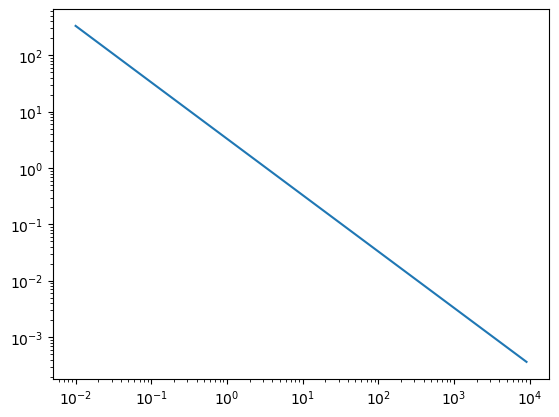

In [7]:
plt.plot(tau_list,SGM_HCD)
plt.xscale('log')
plt.yscale('log')

---
### STQD
---

In [165]:
# for TT in tau_list:
#     save_Had(TT)

In [14]:
NORM_dic_AD = {f"tau_{tau_list.index(_t)}": [] for _t in tau_list}
for TT in tau_list:
    i = tau_list.index(TT)
    dic_H = read_HAD_to_DIC(TT)
    norm_ij = []
    for ij in dic_H:
        A = dic_H[ij]
        y = [ i*i.conjugate() for i in A]
        norm_ij.append(y)
    NORM_dic_AD['tau_'+str(i)] = [np.real(np.sqrt(sum(x)))/TT for x in zip(*norm_ij)]

In [15]:
SGM_HAD = []
for TT in tau_list:
    i = tau_list.index(TT)
    t_list = np.linspace(0,TT,10000)
    S = Cubic_Spline(t_list[0],t_list[-1], NORM_dic_AD['tau_'+str(i)])
    SGM_HAD.append(
        quad(S,0,TT)[0]
    )

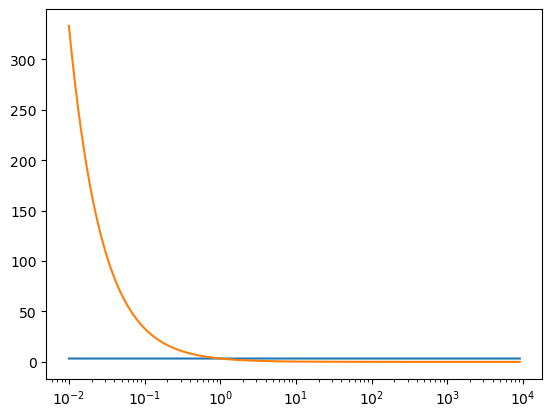

In [10]:
plt.plot(tau_list,SGM_HAD)
plt.plot(tau_list,SGM_HCD)
plt.xscale('log')
# plt.yscale('log')
# plt.ylim(0,300)
plt.show()

In [16]:
NORM_dic_STQD = {f"tau_{tau_list.index(_t)}": [] for _t in tau_list}
for TT in tau_list:
    i = tau_list.index(TT)
    dic_Had = read_HAD_to_DIC(TT)
    dic_Hcd = read_HCD_to_DIC(TT)
    norm_ij = []
    for ij in dic_Had:
        A = dic_Had[ij]
        y = [ i*i.conjugate() for i in A]
        norm_ij.append(y)
    
    for ij in dic_Hcd:
        B = dic_Hcd[ij]
        k = [ i*i.conjugate() for i in B]
        norm_ij.append(k)
    
   

    NORM_dic_STQD['tau_'+str(i)] = [np.real(np.sqrt(sum(x)))/TT for x in zip(*norm_ij)]

In [17]:
SGM_STQD = []
for TT in tau_list:
    i = tau_list.index(TT)
    t_list = np.linspace(0,TT,10000)
    S = Cubic_Spline(t_list[0],t_list[-1], NORM_dic_STQD['tau_'+str(i)])
    SGM_STQD.append(
        quad(S,0,TT)[0]
    )

In [18]:
percent_5 = [i*1.05 for i in SGM_HAD]

In [48]:
tau_list[45]

0.6309573444801936

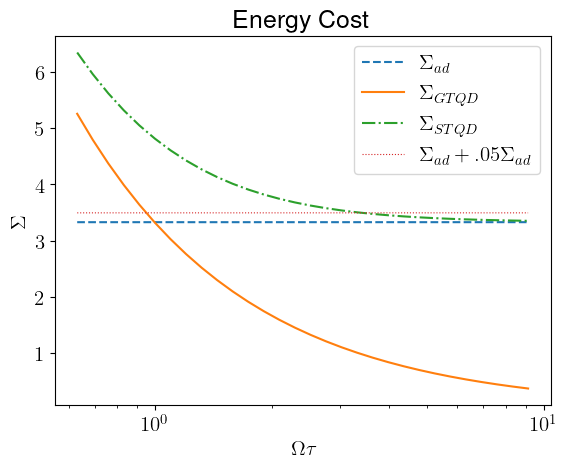

In [62]:


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica"
})
matplotlib.rcParams.update({'font.size': 15})

plt.plot(tau_list[45:75],SGM_HAD[45:75],'--', label="$\Sigma_{ad}$")
plt.plot(tau_list[45:75],SGM_HCD[45:75],label="$\Sigma_{GTQD}$")
plt.plot(tau_list[45:75],SGM_STQD[45:75],'-.',label="$\Sigma_{STQD}$")
plt.plot(tau_list[45:75], percent_5[45:75],':',label="$\Sigma_{ad}+ .05\Sigma_{ad}$  ",lw=.8)
plt.xscale('log')
# plt.yscale('log')
# plt.ylim(0,10)
# plt.xlim(0,10)
plt.title('Energy Cost')
plt.xlabel(r'$\Omega \tau$')
plt.ylabel(r'$\Sigma$')
plt.legend()
plt.show()

0.0002017065919872607

In [85]:
NORM_dic_AD = {f"tau_{tau_list.index(_t)}": [] for _t in tau_list}
for TT in tau_list[:1]:
    i = tau_list.index(TT)
    dic_H = read_HAD_to_DIC(TT)
    # norm_ij = []
    # for H in dic_H:
        # print(H)
    #     A = dic_H[H]
    #     y = [ i*i.conjugate() for i in A[0] ]
    #     norm_ij.append(y)
    # NORM_dic_AD['tau_'+str(i)] = [np.real(np.sqrt(sum(x)))/TT for x in zip(*norm_ij)]

IndexError: list index out of range

In [80]:
A = read_HAD_to_DIC(1.0)

IndexError: list index out of range

In [41]:
TT = 1.0
H = HAD(TT)
nonZero_index_Had = (np.transpose(np.nonzero(H))).tolist()
for i in nonZero_index_Had[:1]:
# -------------------------------------------------------------------------
    dic = { f"{lst[0]}{lst[1]}": [] for lst in nonZero_index_Had[:1] } 
    path = r'data/HAD_components/' +str(TT) + '/'
    for H in dic:
        with open (path + str(H[0]) + str(H[1]), 'rb') as fp:
            A = pickle.load(fp)
        print(dic)
        # dic[H] = [round(z.real, 8) + round(z.imag,8) * 1j for z in A]

{'00': []}


In [29]:
NORM_dic_AD = {f"tau_{tau_list.index(_t)}": [] for _t in tau_list}
for TT in tau_list:
    i = tau_list.index(TT)
    dic_H = read_HAD_to_DIC(TT)
    norm_ij = []
    for H in dic_H:
        A = dic_H[H]
        y = [ i*i.conjugate() for i in A ]
        norm_ij.append(y)
    NORM_dic_AD['tau_'+str(i)] = [np.real(np.sqrt(sum(x)))/TT for x in zip(*norm_ij)]

AttributeError: 'list' object has no attribute 'real'

In [124]:
NormHad

40000.0*Abs(1.0*t**2 - 0.01*t + 0.0001)

In [61]:
total = sum(sum(sublist) for sublist in my_list)

print(total)  

10


In [61]:
NORM_dic = {f"tau_{tau_list.index(_t)}": [] for _t in tau_list[:101]}
for TT in tau_list[:101]:
    i = tau_list.index(TT)
    norm_TT = []
    for ij in nonZero_index_Hcd:
        with open (newpath_GTQD + str(TT)+'_'+str(ij[0])+str(ij[1]), 'rb') as fp:
            Norm_ij_TT = pickle.load(fp)
        norm_TT.append(np.real(Norm_ij_TT[0]))
    
    y = np.sqrt(sum(norm_TT))
    t_list = np.linspace(0,TT,1000)
    s = Cubic_Spline(t_list[0], t_list[-1], y)
    NORM_dic['tau_'+str(i)] = s(t_list)

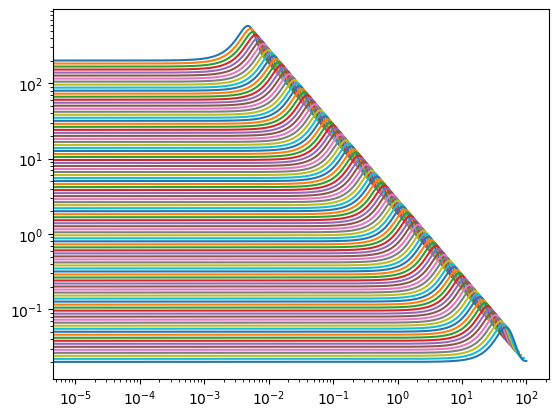

In [62]:
for i,TT in zip(NORM_dic,tau_list):
    x = np.linspace(0,TT,1000)
    y = NORM_dic[i]
    plt.plot(x,y)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [115]:
SgmCD = []
for i,TT in zip(NORM_dic, tau_list):
    
    f = NORM_dic[i] 

    a = 0
    b = TT

    print((b-a)/(len(f)-1))

    SgmCD.append(
        trapz(f/TT,dx= (b-a)/(len(f)-1))
    )


1.001001001001001e-05
1.0975757719151001e-05
1.2034679025199331e-05
1.3195763148712787e-05
1.4468866574033305e-05
1.586479672133247e-05
1.739540369118494e-05
1.9073680860492967e-05
2.091387518372412e-05
2.293160813581355e-05
2.5144008323419226e-05
2.7569856890271934e-05
3.0229746950971132e-05
3.314625840666578e-05
3.6344149626636774e-05
3.9850567622972706e-05
4.369527850251913e-05
4.791092015241624e-05
5.253327930428154e-05
5.760159532904474e-05
6.315889334136069e-05
6.925234944133499e-05
7.593369119411252e-05
8.32596367470141e-05
9.129237631190287e-05
0.0001001001001001001
0.00010975757719151001
0.00012034679025199331
0.00013195763148712784
0.00014468866574033314
0.00015864796721332475
0.00017395403691184948
0.00019073680860492976
0.0002091387518372411
0.00022931608135813537
0.0002514400832341921
0.00027569856890271937
0.0003022974695097113
0.00033146258406665776
0.0003634414962663678
0.00039850567622972706
0.0004369527850251913
0.00047910920152416267
0.0005253327930428157
0.000576015

In [108]:
len(SgmCD)

101

In [109]:
with open ('data/SgmAD', 'rb') as fp:
    SgmAD = pickle.load(fp)

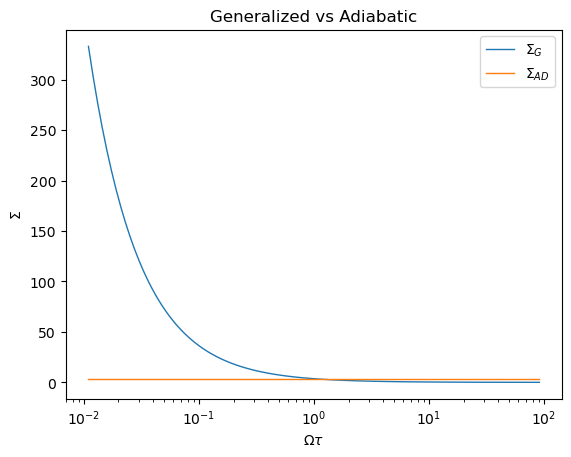

In [118]:
plt.plot(tau_list[1:100],SgmCD[:99], label= r'$\Sigma_{G}$',lw=1)
plt.plot(tau_list[1:100],SgmAD[1:100],label= r'$\Sigma_{AD}$',lw=1)
# plt.plot(tau_list[1:100], ,label= r'$\Sigma_{AD}$',lw=1)
plt.xlabel(r'$\Omega \tau$')
plt.ylabel(r'$\Sigma$')
plt.title('Generalized vs Adiabatic')
# plt.ylim(0,4)
# plt.xlim(0,100)
plt.xscale('log')
plt.legend()
# plt.yscale('log')
plt.show()

In [123]:
newpath_GTQD = r'data/SIGMA_TQD/' 

In [124]:
NORM_dic = {f"tau_{tau_list.index(_t)}": [] for _t in tau_list[:101]}
for TT in tau_list[:101]:
    i = tau_list.index(TT)
    norm_TT = []
    for ij in nonZero_index_Hcd:
        with open (newpath_GTQD + str(TT)+'_'+str(ij[0])+str(ij[1]), 'rb') as fp:
            Norm_ij_TT = pickle.load(fp)
        norm_TT.append(np.real(Norm_ij_TT[0]))
    
    y = np.sqrt(sum(norm_TT))
    t_list = np.linspace(0,TT,1000)
    s = Cubic_Spline(t_list[0], t_list[-1], y)
    NORM_dic['tau_'+str(i)] = s(t_list)

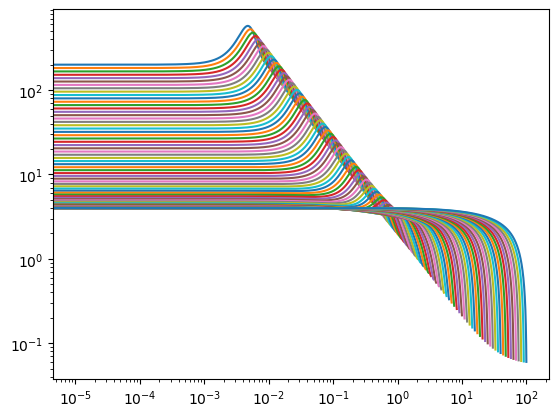

In [125]:
for i,TT in zip(NORM_dic,tau_list):
    x = np.linspace(0,TT,1000)
    y = NORM_dic[i]
    plt.plot(x,y)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [126]:
SgmTQD = []
for i,TT in zip(NORM_dic, tau_list):
    
    f = NORM_dic[i] 

    a = 0
    b = TT

    SgmTQD.append(
        trapz(f/TT,dx=(b-a)/(len(f)-1))
    )


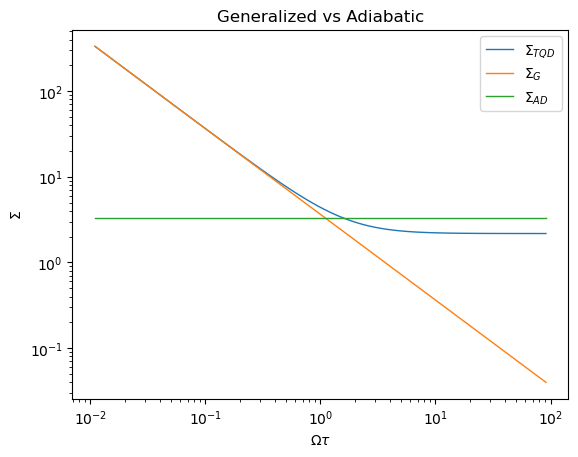

In [127]:
plt.plot(tau_list[1:100],SgmTQD[:99], label= r'$\Sigma_{TQD}$',lw=1)
plt.plot(tau_list[1:100],SgmCD[:99], label= r'$\Sigma_{G}$',lw=1)
plt.plot(tau_list[1:100],SgmAD[1:100],label= r'$\Sigma_{AD}$',lw=1)
# plt.plot(tau_list[1:100], ,label= r'$\Sigma_{AD}$',lw=1)
plt.xlabel(r'$\Omega \tau$')
plt.ylabel(r'$\Sigma$')
plt.title('Generalized vs Adiabatic')
# plt.ylim(0,10)
# plt.xlim(0,100)
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.show()

2.175119234012137

10.0
